In [1]:
# Scratch-work notebook with iterative testing on Choza et al. (2024) data set:
# development of feature list.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import blimpy as bl
from scipy.stats import skew, kurtosis
from scipy import stats
from scipy.interpolate import interp1d
from astropy.stats import sigma_clip
import setigen as stg
from astropy import units as u
import h5py
import psutil
from numba import jit
%matplotlib inline

process = psutil.Process()

print(process.memory_info().rss)

265748480


In [2]:
# Carmen's data

csv_file = '/home/cgchoza/galaxies/complete_cadences_catalog.csv'

df = pd.read_csv(csv_file)

# Personal notes:
# The distribution of these cadences isn't necessarily intuitive;
# there are 459 of them total, but more than 459*6 files
# because some are spliced and some not,
# so some cadences have 6*7 or 6*8 files, 6 for each node,
# etc.

print(process.memory_info().rss)

300367872


In [3]:
# grab only L-band spectra

dfl = df.loc[np.where(df['Band'].values == 'L')[0]]

dfl

,Target,Session,Band,Cadence ID,Frequency,.h5 path,.dat path,Time
0,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
1,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
2,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
3,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
4,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
...,...,...,...,...,...,...,...,...
36553,NGC3226,AGBT22B_999_25,L,411390,1126,/datag/pipeline/AGBT22B_999_25/blc16_blp06/blc...,/home/obs/turboseti/AGBT22B_999_25/blc16_blp06...,2022-11-19 06:13:36
36554,NGC3226,AGBT22B_999_25,L,411390,1126,/datag/pipeline/AGBT22B_999_25/blc16_blp06/blc...,/home/obs/turboseti/AGBT22B_999_25/blc16_blp06...,2022-11-19 06:13:36
36555,NGC3226,AGBT22B_999_25,L,411390,1126,/datag/pipeline/AGBT22B_999_25/blc16_blp06/blc...,/home/obs/turboseti/AGBT22B_999_25/blc16_blp06...,2022-11-19 06:13:36
36556,NGC3226,AGBT22B_999_25,L,411390,1126,/datag/pipeline/AGBT22B_999_25/blc16_blp06/blc...,/home/obs/turboseti/AGBT22B_999_25/blc16_blp06...,2022-11-19 06:13:36


In [4]:
print(process.memory_info().rss)

245243904


In [ ]:
@jit
def make_snippets(input_arr, freqs_list, half_window):
    snippet_array = [input_arr[:,:,ctrfreq-half_window:ctrfreq+half_window] for ctrfreq in freqs_list]
    return snippet_array

# helper function from B. Brzycki to calculate signal bandwidths

def threshold_baseline_bounds(spec, p=0.01):
    """
    Create bounds based on integrated intensity on either side of the central
    peak, as a fraction of the peak integrated intensity. Uses a 1D fit to the
    noise baseline.
    
    Parameters
    ----------
    spec : ndarray
        Intensity spectra
    p : float, optional
        Fraction of peak, used to set left and right bounds
        
    Returns
    -------
    l : int
        Left bound
    r : int
        Right bound
    metadata : dict
        Dictionary with metadata. Contains noise mean and spectra maximum,
        which are used to normalize spec to the spectra maximum.
    """
    noise_spec = sigma_clip(spec, masked=True)
    x = np.arange(len(spec))

    coeffs = np.polyfit(x[~noise_spec.mask], noise_spec[~noise_spec.mask], 1)
    poly = np.poly1d(coeffs)
    
    spec = spec - poly(x)
    norm_spec = (spec ) / (np.max(spec) )
    
    cutoffs = np.where(norm_spec < p)[0]
    
    peak = np.argmax(norm_spec)
    i = np.digitize(peak, cutoffs) - 1
    # print(i, i+1, len(cutoffs), len(spec), cutoffs[-1])
    l = cutoffs[i] + 1
    if i+1 < len(cutoffs):
        r = cutoffs[i + 1]
    else:
        r = cutoffs[i]
    
    metadata = {
        'noise_mean': np.mean(noise_spec),
        'spec_max': np.max(spec)
    }
    return l, r, metadata

def get_parameters(inp_dat):

    input_arr = inp_dat[0]
    ctrfreq = inp_dat[1]
    drift = inp_dat[2]

    f_len = input_arr.shape[1]
    power_spectrum = np.average(input_arr[:, f_len//2-caleb_wl_in_idxs//2:f_len//2+caleb_wl_in_idxs//2], axis=0)
    power_spectrum = (power_spectrum-np.median(power_spectrum)) # subtract
    power_spectrum = power_spectrum / power_spectrum.max()      # and divide
    sk = skew(power_spectrum)
    ku = kurtosis(power_spectrum, fisher=False)
    sarle = (sk**2 + 1) / ku
    fstd = np.std(power_spectrum)
    
    time_series = np.average(input_arr, axis=1)
    normalized_time_series = (time_series-np.median(time_series))/np.max(time_series-np.median(time_series))
    tsk = skew(normalized_time_series)
    tstd = np.std(normalized_time_series)

    # calculate spectral kurtosis for varying spectral window size

    window_lengths = np.logspace(np.log10(0.0002), np.log10(0.1000), 50) # from 2 kHz to 100 kHz
    mini_kurts = []

    full_power_spectrum = np.average(input_arr, axis=0)

    for wl in window_lengths:
        wl_in_idxs = round(wl/np.abs(foff))
        #print(wl_in_idxs//2)
        ps_slice = full_power_spectrum[f_len//2-wl_in_idxs//2:f_len//2+wl_in_idxs//2]
        ps_slice = ps_slice / ps_slice.max()
        mk = kurtosis(ps_slice, fisher=False)
        mini_kurts.append(mk)

    if (np.argmax(mini_kurts) == len(mini_kurts) - 1) or (np.argmax(mini_kurts) == 0):
        tbw = window_lengths[np.argmax(mini_kurts)]
    else:
        idx_max = np.argmax(mini_kurts)
        xxx = np.log10(1e6*np.array(window_lengths))
        x_m = xxx[idx_max-1:idx_max+2]
        y_m = mini_kurts[idx_max-1:idx_max+2]

        # linear algebra to find best-fit parabola
        denom = (x_m[0] - x_m[1])*(x_m[0] - x_m[2])*(x_m[1] - x_m[2])
        a = (x_m[2] * (y_m[1] - y_m[0]) + x_m[1] * (y_m[0] - y_m[2]) + x_m[0] * (y_m[2] - y_m[1])) / denom
        b = (x_m[2]**2 * (y_m[0] - y_m[1]) + x_m[1]**2 * (y_m[2] - y_m[0]) + x_m[0]**2 * (y_m[1] - y_m[2])) / denom
        c = (x_m[1] * x_m[2] * (x_m[1] - x_m[2]) * y_m[0] + x_m[2] * x_m[0] * (x_m[2] - x_m[0]) * y_m[1] + x_m[0] * x_m[1] * (x_m[0] - x_m[1]) * y_m[2]) / denom

        # vertex coords
        x0 = -b / (2 * a)
        #y0 = a * x0**2 + b * x0 + c

        tbw = 10**x0 / 1e6
        
    subset_kurtoses = np.array(mini_kurts)[np.where(window_lengths <= caleb_wl)[0]]
    subset_windows = window_lengths[np.where(window_lengths <= caleb_wl)[0]]

    corr = stats.pearsonr(np.log10(subset_windows), subset_kurtoses)[0]

    sigbw_calc_ds = input_arr[:,f_len//2-sigbw_wl_in_idxs//2:f_len//2+sigbw_wl_in_idxs//2]
        
    frame = stg.Frame.from_data(df=np.abs(foff)*u.MHz,
                            dt=18.253611008*u.s,
                            fch1=(ctrfreq-sigbw_calc_wl/2)*u.MHz,
                            ascending=True, # fch1 is a minimum
                            data=sigbw_calc_ds)
    
    dd_fr = stg.dedrift(frame, -drift) # not sure why the negative is needed, but it works for me

    spec = stg.integrate(dd_fr)

    l, r, _ = threshold_baseline_bounds(spec)

    sigbw = (float(r)-float(l))*np.abs(foff)

    # 0: frequency [MHz]
    #1: drift rate [Hz/s]
    #2: SNR
    #3: spectral skewness
    #4: spectral kurtosis
    #5: Sarle's coefficient
    #6: correlation coefficient [kurtosis vs. log(bandwidth)]
    #7: turning-point bandwidth [Hz]
    #8: temporal skewness
    #9: time-series standard deviation
    #10: power-spectrum standard deviation
    #11: signal bandwidth

    return np.array([sk, ku, sarle, corr, tbw, tsk, tstd, fstd, sigbw])

In [ ]:
del df

caleb_wl = 0.002700 # 2.7 kHz
sigbw_calc_wl = 0.00500 # 5.4 kHz
full_wl = 0.100000 # 100 kHz

for iii in range(len(dfl)):

    print(f'File {iii+1} out of {len(dfl)}')

    f = h5py.File(dfl['.h5 path'].values[iii], 'r')
    dset = f['data']

    fch1 = dset.attrs['fch1']
    foff = dset.attrs['foff']

    freqs = np.linspace(fch1, fch1+foff*dset.shape[2], dset.shape[2])

    dat_path = dfl['.dat path'].values[iii]

    df_dat = pd.read_table(dat_path, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                'Full_number_of_hits'], skiprows=9)
        
    ctrfreqs = df_dat['Uncorrected_Frequency'].values
    drifts = df_dat['Drift_Rate'].values

    ctrfreqs_in_idxs = (ctrfreqs - fch1)/foff


    caleb_wl_in_idxs = round(caleb_wl/np.abs(foff))
    sigbw_wl_in_idxs = round(sigbw_calc_wl/np.abs(foff))
    full_wl_in_idxs = round(full_wl/np.abs(foff))
    
    snippets = make_snippets(dset, ctrfreqs_in_idxs.astype(int), full_wl_in_idxs)

    snippets = np.squeeze(np.array(snippets))

    inputs = [[snippets[i], ctrfreqs[i], drifts[i]] for i in range(len(ctrfreqs))]
    vecs = map(get_parameters, inputs)
    params = np.array(list(vecs))


In [4]:
f = h5py.File(dfl['.h5 path'].values[0], 'r')

In [5]:
list(f.keys())

['data', 'mask']

In [6]:
dset = f['data']
print(dset.shape)
print(dset.dtype)

(32, 1, 536870912)
float32


In [7]:
print(process.memory_info().rss)

301678592


In [8]:
fch1 = dset.attrs['fch1']
foff = dset.attrs['foff']

print(dset.shape[2])

freqs = np.linspace(fch1, fch1+foff*dset.shape[2], dset.shape[2])

dat_path = dfl['.dat path'].values[0]

df_dat = pd.read_table(dat_path, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    
ctrfreqs = df_dat['Uncorrected_Frequency'].values
drifts = df_dat['Drift_Rate'].values

print(process.memory_info().rss)

536870912
4596981760


In [13]:
del df
print(process.memory_info().rss)

4536565760


In [81]:
delta_f = 2.7939677238464355    # frequency resolution for HSR data
print(foff)

-2.7939677238464355e-06


[202280.91691699 309617.16043929 349825.92843652 404984.04593538
 416954.11978939]
[202280 309617 349825 404984 416954]


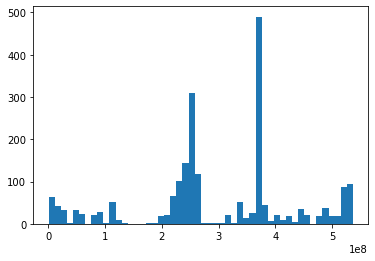

In [11]:
ctrfreqs_in_idxs = (ctrfreqs - fch1)/foff

print(ctrfreqs_in_idxs[:5])
print(ctrfreqs_in_idxs.astype(int)[:5])

plt.hist(ctrfreqs_in_idxs, bins=50)
plt.show()

In [15]:
print(ctrfreqs_in_idxs.min())

202280.9169169922


In [15]:
from numba import jit

In [16]:
@jit
def make_snippets(input_arr, freqs_list, half_window):
    snippet_array = [input_arr[:,:,ctrfreq-half_window:ctrfreq+half_window] for ctrfreq in freqs_list]
    return snippet_array

In [17]:
caleb_wl = 0.002700 # 2.7 kHz
sigbw_calc_wl = 0.00500 # 5.4 kHz
full_wl = 0.100000 # 100 kHz

caleb_wl_in_idxs = round(caleb_wl/np.abs(foff))
sigbw_wl_in_idxs = round(sigbw_calc_wl/np.abs(foff))
full_wl_in_idxs = round(full_wl/np.abs(foff))

print(caleb_wl_in_idxs)

966


In [18]:
#snippets = [dset[:,:,ctrfreq-caleb_wl_in_idxs:ctrfreq+caleb_wl_in_idxs] for ctrfreq in ctrfreqs_in_idxs.astype(int)]
print(process.memory_info().rss)

snippets = make_snippets(dset, ctrfreqs_in_idxs.astype(int), full_wl_in_idxs)

print(np.array(snippets).shape)
print(process.memory_info().rss)

4586078208
numba.transforms INFO     finding looplift candidates


<ipython-input-16-86f6b1678cfc>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_snippets" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-16-86f6b1678cfc> (3)

File "<ipython-input-16-86f6b1678cfc>", line 3:
def make_snippets(input_arr, freqs_list, half_window):
    snippet_array = [input_arr[:,:,ctrfreq-half_window:ctrfreq+half_window] for ctrfreq in freqs_list]
    ^

  @jit
/opt/conda/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "make_snippets" was compiled in object mode without forceobj=True.

File "<ipython-input-16-86f6b1678cfc>", line 2:
@jit
def make_snippets(input_arr, freqs_list, half_window):
^

  state.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/numba/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is 

(2136, 32, 1, 71582)
24169803776


In [19]:
squeezed_snippets = np.squeeze(np.array(snippets))
print(process.memory_info().rss)

43740901376


In [20]:
del snippets
print(process.memory_info().rss)

24178569216


In [21]:
squeezed_snippets = np.expand_dims(squeezed_snippets, 1)
print(process.memory_info().rss)

24178569216


In [14]:
def get_parameters(inp_dat):

    input_arr = inp_dat[0]
    ctrfreq = inp_dat[1]
    drift = inp_dat[2]

    f_len = input_arr.shape[1]
    power_spectrum = np.average(input_arr[:, f_len//2-caleb_wl_in_idxs//2:f_len//2+caleb_wl_in_idxs//2], axis=0)
    power_spectrum = (power_spectrum-np.median(power_spectrum)) # subtract
    power_spectrum = power_spectrum / power_spectrum.max()      # and divide
    sk = skew(power_spectrum)
    ku = kurtosis(power_spectrum, fisher=False)
    sarle = (sk**2 + 1) / ku
    fstd = np.std(power_spectrum)
    
    time_series = np.average(input_arr, axis=1)
    normalized_time_series = (time_series-np.median(time_series))/np.max(time_series-np.median(time_series))
    tsk = skew(normalized_time_series)
    tstd = np.std(normalized_time_series)

    # calculate spectral kurtosis for varying spectral window size

    window_lengths = np.logspace(np.log10(0.0002), np.log10(0.1000), 50) # from 2 kHz to 100 kHz
    mini_kurts = []

    full_power_spectrum = np.average(input_arr, axis=0)

    for wl in window_lengths:
        wl_in_idxs = round(wl/np.abs(foff))
        #print(wl_in_idxs//2)
        ps_slice = full_power_spectrum[f_len//2-wl_in_idxs//2:f_len//2+wl_in_idxs//2]
        ps_slice = ps_slice / ps_slice.max()
        mk = kurtosis(ps_slice, fisher=False)
        mini_kurts.append(mk)

    if (np.argmax(mini_kurts) == len(mini_kurts) - 1) or (np.argmax(mini_kurts) == 0):
        tbw = window_lengths[np.argmax(mini_kurts)]
    else:
        idx_max = np.argmax(mini_kurts)
        xxx = np.log10(1e6*np.array(window_lengths))
        x_m = xxx[idx_max-1:idx_max+2]
        y_m = mini_kurts[idx_max-1:idx_max+2]

        # linear algebra to find best-fit parabola
        denom = (x_m[0] - x_m[1])*(x_m[0] - x_m[2])*(x_m[1] - x_m[2])
        a = (x_m[2] * (y_m[1] - y_m[0]) + x_m[1] * (y_m[0] - y_m[2]) + x_m[0] * (y_m[2] - y_m[1])) / denom
        b = (x_m[2]**2 * (y_m[0] - y_m[1]) + x_m[1]**2 * (y_m[2] - y_m[0]) + x_m[0]**2 * (y_m[1] - y_m[2])) / denom
        c = (x_m[1] * x_m[2] * (x_m[1] - x_m[2]) * y_m[0] + x_m[2] * x_m[0] * (x_m[2] - x_m[0]) * y_m[1] + x_m[0] * x_m[1] * (x_m[0] - x_m[1]) * y_m[2]) / denom

        # vertex coords
        x0 = -b / (2 * a)
        #y0 = a * x0**2 + b * x0 + c

        tbw = 10**x0 / 1e6
        
    subset_kurtoses = np.array(mini_kurts)[np.where(window_lengths <= caleb_wl)[0]]
    subset_windows = window_lengths[np.where(window_lengths <= caleb_wl)[0]]

    corr = stats.pearsonr(np.log10(subset_windows), subset_kurtoses)[0]

    sigbw_calc_ds = input_arr[:,f_len//2-sigbw_wl_in_idxs//2:f_len//2+sigbw_wl_in_idxs//2]
        
    frame = stg.Frame.from_data(df=np.abs(foff)*u.MHz,
                            dt=18.253611008*u.s,
                            fch1=(ctrfreq-sigbw_calc_wl/2)*u.MHz,
                            ascending=True, # fch1 is a minimum
                            data=sigbw_calc_ds)
    
    dd_fr = stg.dedrift(frame, -drift) # not sure why the negative is needed, but it works for me

    spec = stg.integrate(dd_fr)

    l, r, _ = threshold_baseline_bounds(spec)

    sigbw = (float(r)-float(l))*np.abs(foff)

    return np.array([sk, ku, sarle, tsk, fstd, tstd, tbw, corr, sigbw])

In [15]:
inputs = [[squeezed_snippets[i], ctrfreqs[i], drifts[i]] for i in range(len(ctrfreqs))]

In [150]:
vecs = map(get_parameters, inputs)

In [173]:
import tracemalloc
from collections import Counter
import linecache
import os

In [16]:
import psutil

In [19]:
print(process.memory_info().rss)

inputs = [[squeezed_snippets[i], ctrfreqs[i], drifts[i]] for i in range(len(ctrfreqs))]

print(process.memory_info().rss)

vecs = map(get_parameters, inputs)

print(process.memory_info().rss)

params = np.array(list(vecs))
#print(params)

print(process.memory_info().rss)

43802980352
43802980352
43802980352
43805929472


In [18]:
# helper function from B. Brzycki to calculate signal bandwidths

def threshold_baseline_bounds(spec, p=0.01):
    """
    Create bounds based on integrated intensity on either side of the central
    peak, as a fraction of the peak integrated intensity. Uses a 1D fit to the
    noise baseline.
    
    Parameters
    ----------
    spec : ndarray
        Intensity spectra
    p : float, optional
        Fraction of peak, used to set left and right bounds
        
    Returns
    -------
    l : int
        Left bound
    r : int
        Right bound
    metadata : dict
        Dictionary with metadata. Contains noise mean and spectra maximum,
        which are used to normalize spec to the spectra maximum.
    """
    noise_spec = sigma_clip(spec, masked=True)
    x = np.arange(len(spec))

    coeffs = np.polyfit(x[~noise_spec.mask], noise_spec[~noise_spec.mask], 1)
    poly = np.poly1d(coeffs)
    
    spec = spec - poly(x)
    norm_spec = (spec ) / (np.max(spec) )
    
    cutoffs = np.where(norm_spec < p)[0]
    
    peak = np.argmax(norm_spec)
    i = np.digitize(peak, cutoffs) - 1
    # print(i, i+1, len(cutoffs), len(spec), cutoffs[-1])
    l = cutoffs[i] + 1
    if i+1 < len(cutoffs):
        r = cutoffs[i + 1]
    else:
        r = cutoffs[i]
    
    metadata = {
        'noise_mean': np.mean(noise_spec),
        'spec_max': np.max(spec)
    }
    return l, r, metadata

In [106]:
all_freqs = []
all_drifts = []
all_snrs = []
all_kurts = []
all_skews = []
all_sarles = []
all_tbws = []
all_corrs = []
all_tskews = []
all_tstds = []
all_fstds = []
all_sigbws = []

delta_f = 2.7939677238464355    # frequency resolution for HSR data

for i in range(len(dfl)):

    print(f'Starting {i+1} of {len(dfl)} ...')

    dat_path = dfl['.dat path'].values[i]
    h5_path = dfl['.h5 path'].values[i]

    df_dat = pd.read_table(dat_path, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    
    ctrfreqs = df_dat['Uncorrected_Frequency'].values
    drifts = df_dat['Drift_Rate'].values
    snrs = df_dat['SNR'].values

    fb = bl.Waterfall(h5_path)

    caleb_wl = 0.002700    # 2.7 kHz window size, from Caleb Painter's work

    ds_freqs, full_dynamic_spectrum = fb.grab_data()

    kurts = []
    skews = []
    sarles = []
    tbws = []
    corrs = []
    tskews = []
    tstds = []
    fstds = []
    sigbws = []

    for ii, freq in enumerate(ctrfreqs):

        print(f'Beginning analysis of hit at frequency {freq} MHz ({ii+1} of {len(ctrfreqs)})...')

        dynamic_spectrum = full_dynamic_spectrum[:,np.where((ds_freqs < freq+caleb_wl/2) & (ds_freqs > freq-caleb_wl/2))[0]]
        
        power_spectrum = np.average(dynamic_spectrum, axis=0)
        power_spectrum = (power_spectrum-np.median(power_spectrum)) # subtract
        power_spectrum = power_spectrum / power_spectrum.max()      # and divide
        fstd = np.std(power_spectrum)

        ku = kurtosis(power_spectrum, fisher=False)  # Pearson (not Fisher) for Sarle calculation
        sk = skew(power_spectrum)
        sarle = (sk**2 + 1) / ku           # Sarle's bimodality coefficient
                                        # = 5/9 for uniform, larger possibly suggests multimodality
        time_series = np.average(dynamic_spectrum, axis=1)
        normalized_time_series = (time_series-np.median(time_series))/np.max(time_series-np.median(time_series))
        tsk = skew(normalized_time_series)
        tstd = np.std(normalized_time_series)

        kurts.append(ku)
        skews.append(sk)
        sarles.append(sarle)
        tskews.append(tsk)
        tstds.append(tstd)
        fstds.append(fstd)

        # calculate spectral kurtosis for varying spectral window size

        window_lengths = np.logspace(np.log10(0.0002), np.log10(0.1000), 50)
        mini_kurts = []

        for wl in window_lengths:
            dynamic_spectrum = full_dynamic_spectrum[:,np.where((ds_freqs < freq+wl/2) & (ds_freqs > freq-wl/2))[0]]
            power_spectrum = np.average(dynamic_spectrum, axis=0)
            power_spectrum = power_spectrum / power_spectrum.max()
            mk = kurtosis(power_spectrum, fisher=False)
            #print(f'Spectral kurtosis is {mk} for bandwidth {round(1e6*wl)} Hz.')
            mini_kurts.append(mk)
        
        if (np.argmax(mini_kurts) == len(mini_kurts) - 1) or (np.argmax(mini_kurts) == 0):
            turning_bandwidth = window_lengths[np.argmax(mini_kurts)]
        else:
            idx_max = np.argmax(mini_kurts)
            xxx = np.log10(1e6*np.array(window_lengths))
            x_m = xxx[idx_max-1:idx_max+2]
            y_m = mini_kurts[idx_max-1:idx_max+2]

            # linear algebra to find best-fit parabola
            denom = (x_m[0] - x_m[1])*(x_m[0] - x_m[2])*(x_m[1] - x_m[2])
            a = (x_m[2] * (y_m[1] - y_m[0]) + x_m[1] * (y_m[0] - y_m[2]) + x_m[0] * (y_m[2] - y_m[1])) / denom
            b = (x_m[2]**2 * (y_m[0] - y_m[1]) + x_m[1]**2 * (y_m[2] - y_m[0]) + x_m[0]**2 * (y_m[1] - y_m[2])) / denom
            c = (x_m[1] * x_m[2] * (x_m[1] - x_m[2]) * y_m[0] + x_m[2] * x_m[0] * (x_m[2] - x_m[0]) * y_m[1] + x_m[0] * x_m[1] * (x_m[0] - x_m[1]) * y_m[2]) / denom

            # vertex coords
            x0 = -b / (2 * a)
            y0 = a * x0**2 + b * x0 + c

            turning_bandwidth = 10**x0 / 1e6
        
        tbws.append(turning_bandwidth)

        subset_kurtoses = np.array(mini_kurts)[np.where(window_lengths <= caleb_wl)[0]]
        subset_windows = window_lengths[np.where(window_lengths <= caleb_wl)[0]]

        correlation_coefficient = stats.pearsonr(np.log10(subset_windows), subset_kurtoses)[0]
        corrs.append(correlation_coefficient)

        # calculate signal bandwidth using B. Brzycki functions

        if np.abs(drifts[ii]) > 3:  # ad hoc fix for some widths extending outside the 2.7-kHz window (mainly satellites)
            sigbw_calc_wl = 2*caleb_wl
        else:
            sigbw_calc_wl = caleb_wl

        sigbw_calc_ds = full_dynamic_spectrum[:,np.where(
                (ds_freqs < freq+sigbw_calc_wl/2) & (ds_freqs > freq-sigbw_calc_wl/2))[0]]
        
        frame = stg.Frame.from_data(df=delta_f*u.Hz,
                            dt=18.253611008*u.s,
                            fch1=(freq-sigbw_calc_wl/2)*u.MHz,
                            ascending=True, # fch1 is a minimum
                            data=sigbw_calc_ds)
    
        dd_fr = stg.dedrift(frame, -drifts[ii]) # not sure why the negative is needed, but it works for me

        spec = stg.integrate(dd_fr)

        l, r, _ = threshold_baseline_bounds(spec)

        signal_bw = (float(r)-float(l))*delta_f
        sigbws.append(signal_bw)

        

    all_freqs = np.concatenate((all_freqs, ctrfreqs))
    all_drifts = np.concatenate((all_drifts, drifts))
    all_snrs = np.concatenate((all_snrs, snrs))
    all_kurts = np.concatenate((all_kurts, np.array(kurts)))
    all_skews = np.concatenate((all_skews, np.array(skews)))
    all_sarles = np.concatenate((all_sarles, np.array(sarles)))
    all_tbws = np.concatenate((all_tbws, np.array(tbws)))
    all_corrs = np.concatenate((all_corrs, np.array(corrs)))
    all_tskews = np.concatenate((all_tskews, np.array(tskews)))
    all_tstds = np.concatenate((all_tstds, np.array(tstds)))
    all_fstds = np.concatenate((all_fstds, np.array(fstds)))
    all_sigbws = np.concatenate((all_sigbws, np.array(sigbws)))

Starting 1 of 5454 ...
Beginning analysis of hit at frequency 2250.899676 MHz (1 of 2136)...
Beginning analysis of hit at frequency 2250.599782 MHz (2 of 2136)...
Beginning analysis of hit at frequency 2250.48744 MHz (3 of 2136)...
Beginning analysis of hit at frequency 2250.33333 MHz (4 of 2136)...
Beginning analysis of hit at frequency 2250.299886 MHz (5 of 2136)...
Beginning analysis of hit at frequency 2250.283584 MHz (6 of 2136)...
Beginning analysis of hit at frequency 2250.243767 MHz (7 of 2136)...
Beginning analysis of hit at frequency 2250.187488 MHz (8 of 2136)...
Beginning analysis of hit at frequency 2250.166659 MHz (9 of 2136)...


KeyboardInterrupt: 

In [78]:
print(len(all_freqs))
print(len(all_drifts))
print(len(all_snrs))

3247717
3247717
3247717


In [89]:
legal_idxs = np.where(
    ((all_freqs > 1340) & (all_freqs < 1900))
    |
    ((all_freqs > 1100) & (all_freqs < 1200))
    )[0]

print(len(legal_idxs))

2186151


In [98]:
np.save('/datax/scratch/benjb/C23_L_frequencies.npy', all_freqs[legal_idxs])
np.save('/datax/scratch/benjb/C23_L_driftrates.npy', all_drifts[legal_idxs])
np.save('/datax/scratch/benjb/C23_L_snrs.npy', all_snrs[legal_idxs])

In [100]:
ff = np.load('/datax/scratch/benjb/C23_L_frequencies.npy', allow_pickle=True)
print(len(ff))

2186151


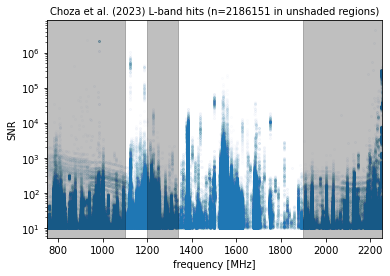

In [96]:
plt.rcParams.update({'axes.titlesize': 'medium'})

plt.scatter(all_freqs, all_snrs, s=5, alpha=0.01)
#plt.scatter(all_freqs[legal_idxs], all_snrs[legal_idxs], s=5)
plt.axvspan(1200, 1340, color='k', alpha=0.25)
plt.axvspan(all_freqs.min(), 1100, color='k', alpha=0.25)
plt.axvspan(1900, all_freqs.max(), color='k', alpha=0.25)
plt.yscale('log')
plt.xlim(all_freqs.min(), all_freqs.max())
plt.xlabel('frequency [MHz]')
plt.ylabel('SNR')
plt.title(f'Choza et al. (2023) L-band hits (n={len(legal_idxs)} in unshaded regions)')
plt.savefig('/datax/scratch/benjb/C23_L_hits_snr_vs_frequency.png', transparent=False)
plt.show()

In [23]:
h5_path = df['.h5 path'][36556]

fb = bl.Waterfall(h5_path, load_data=False)

In [24]:
fb.info()


--- File Info ---
DIMENSION_LABELS : [b'time' b'feed_id' b'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :                1126.46484375 MHz
            foff :      -2.7939677238464355e-06 MHz
           ibeam :                                1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                         67108864
            nfpc :                          1048576
            nifs :                                1
     rawdatafile : guppi_59902_23686_NGC3226_0056.0000.raw
     source_name :                          NGC3226
         src_dej :                       19:54:28.8
         src_raj :                     10:23:19.512
    telescope_id :                                6
           tsamp :               18.253611007999982
   tstart (ISOT) :          2022-11-1

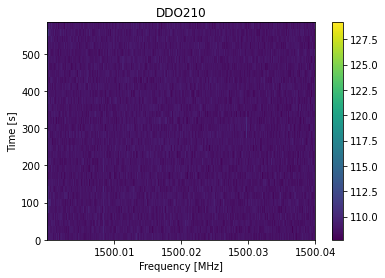

In [15]:
fb.plot_waterfall(f_start=1500, f_stop=1500.04)

In [41]:
import bldw

In [42]:
c = bldw.Connection()

In [76]:
target_list = c.fetch_all_targets()
refined_list = []
for t in target_list:
    #if (not 'HIP' in t.__str__()) and (not 'TIC' in t.__str__()):
    if 'NGC655' in t.__str__():
        refined_list.append(t)

In [77]:
for t in refined_list:
    print(t)

98669, NGC6553, 18.154355333, -25.90775, 0.3, -0.41, J2000


In [73]:
c.fetch_target_dict([98583])

{98583: <bldw.Target object at 0x75fea1a0ee90>}


In [62]:
obs_list = c.fetch_observations_by_target(98583)

In [86]:
for obs in obs_list:
    print(obs)
print(len(obs_list))

observation with id = 413513 at utc = 2023-04-24 17:13:01 (1682356381)
observation with id = 413520 at utc = 2023-04-24 17:02:21 (1682355741)
observation with id = 413533 at utc = 2023-04-24 17:23:39 (1682357019)
observation with id = 413895 at utc = 2023-05-09 15:40:17 (1683646817)
observation with id = 413964 at utc = 2023-05-09 15:29:39 (1683646179)
observation with id = 414008 at utc = 2023-05-09 15:18:59 (1683645539)
observation with id = 416445 at utc = 2023-06-25 13:04:49 (1687698289)
observation with id = 416470 at utc = 2023-06-25 13:15:29 (1687698929)
observation with id = 416512 at utc = 2023-06-25 13:26:22 (1687699582)
observation with id = 425185 at utc = 2024-02-18 21:20:13 (1708291213)
observation with id = 425195 at utc = 2024-02-18 20:58:57 (1708289937)
observation with id = 425201 at utc = 2024-02-18 21:09:41 (1708290581)
12


In [90]:
for i in range(len(c.fetch_metadata_by_observation_id(425195))):
    filename = c.fetch_metadata_by_observation_id(425195)[i].filename()
    print(filename)
    if 'datag' in filename:
        fb = bl.Waterfall(filename, load_data=False)
        fb.info()

/mnt_bls7/datax/pipeline/AGBT23B_999_43/blc63_blp23/blc63_guppi_60358_75537_MESSIER15_0021.rawspec.0000.h5
/mnt_bls7/datax/pipeline/AGBT23B_999_43/blc63_blp23/blc63_guppi_60358_75537_MESSIER15_0021.rawspec.0001.h5
/mnt_bls7/datax/pipeline/AGBT23B_999_43/blc63_blp23/blc63_guppi_60358_75537_MESSIER15_0021.rawspec.0002.h5
/mnt_bls6/datax2/pipeline/AGBT23B_999_43/blc75_blp35/blc75_guppi_60358_75537_MESSIER15_0021.rawspec.0000.h5
/mnt_bls6/datax2/pipeline/AGBT23B_999_43/blc75_blp35/blc75_guppi_60358_75537_MESSIER15_0021.rawspec.0001.h5
/mnt_bls6/datax2/pipeline/AGBT23B_999_43/blc75_blp35/blc75_guppi_60358_75537_MESSIER15_0021.rawspec.0002.h5
/mnt_bls7/datax3/pipeline/AGBT23B_999_43/blc44_blp04/blc44_guppi_60358_75537_MESSIER15_0021.rawspec.0000.h5
/mnt_bls7/datax3/pipeline/AGBT23B_999_43/blc44_blp04/blc44_guppi_60358_75537_MESSIER15_0021.rawspec.0001.h5
/mnt_bls7/datax3/pipeline/AGBT23B_999_43/blc44_blp04/blc44_guppi_60358_75537_MESSIER15_0021.rawspec.0002.h5
/mnt_bls5/datax/pipeline/AGBT23

In [82]:
help(fb)

Help on Waterfall in module blimpy.waterfall object:

class Waterfall(builtins.object)
 |  Waterfall(filename=None, f_start=None, f_stop=None, t_start=None, t_stop=None, load_data=True, max_load=None, header_dict=None, data_array=None)
 |  
 |  Class for loading and writing blimpy data (.fil, .h5)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename=None, f_start=None, f_stop=None, t_start=None, t_stop=None, load_data=True, max_load=None, header_dict=None, data_array=None)
 |      Class for loading and plotting blimpy data.
 |      
 |      This class parses the blimpy file and stores the header and data
 |      as objects:
 |          fb = Waterfall('filename_here.fil')
 |          fb.header        # blimpy header, as a dictionary
 |          fb.data          # blimpy data, as a numpy array
 |      
 |      Args:
 |          filename (str): filename of blimpy file.  REQUIRED.
 |          f_start (float): start frequency in MHz
 |          f_stop (float): stop frequency in M